In [39]:
import pandas as pd
import numpy as np

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data

 93% 165M/178M [00:01<00:00, 115MB/s] 
100% 178M/178M [00:01<00:00, 95.1MB/s]


In [ ]:
import zipfile
zip=zipfile.ZipFile('/content/fraudulent-transactions-data.zip')
zip.extractall()
zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/fraudulent-transactions-data.zip' mode='r'>>

In [ ]:
data=pd.read_csv('Fraud.csv')

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [ ]:
non_fraud=len(data[data.isFraud==0])
fraud=len(data[data.isFraud==1])
print('non_fraud = ',non_fraud)
print('fraud = ',fraud)

non_fraud =  6354407
fraud =  8213


**High Class Imbalance, Hence Random Forest and Decision Trees can be Used.**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-11-171970bbb93b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=data.corr()


<Axes: >

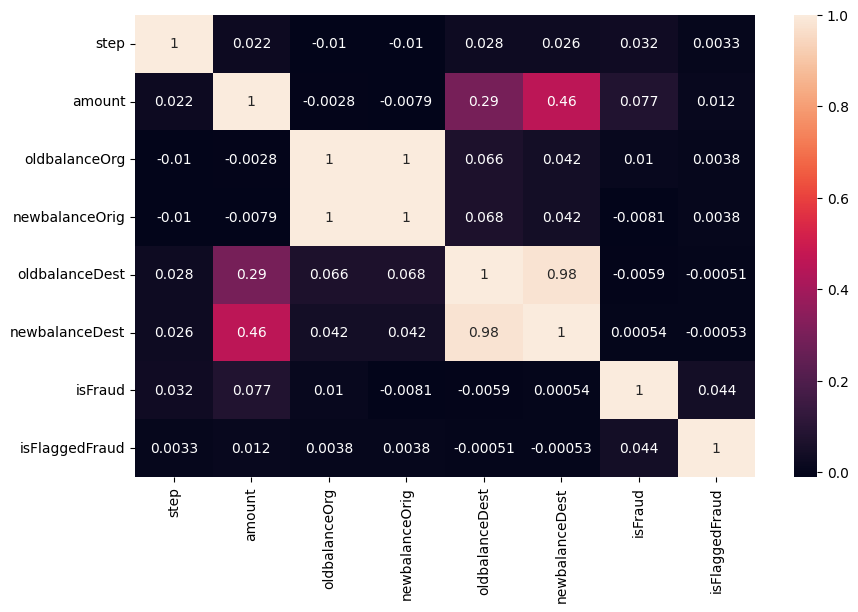

In [ ]:
corr=data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [ ]:
data1=data.copy()
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data1['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
objects = data1.select_dtypes(include = "object").columns
print (objects)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for column in objects:
    data1[column] = encoder.fit_transform(data[column].astype(str))

In [ ]:
data1['nameOrig'].unique()

array([ 757869, 2188998, 1002156, ...,  533958, 2252932,  919229])

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(data):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

calc_vif(data1)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [ ]:
data1['Actual_amount_orig'] = data1.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
data1['Actual_amount_dest'] = data1.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
data1['TransactionPath'] = data1.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
data1 = data1.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(data1)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

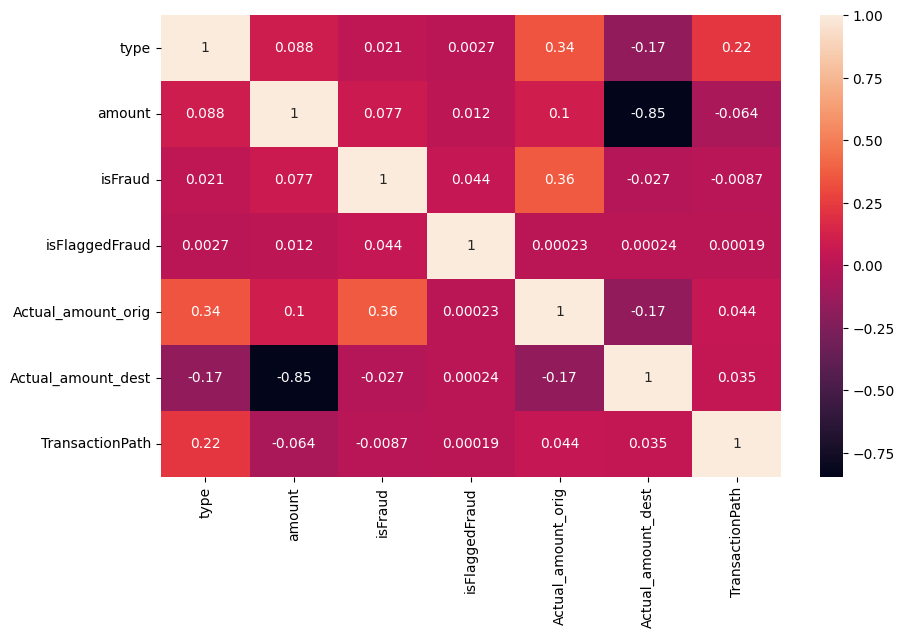

In [ ]:
corr1=data1.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr1,annot=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
data1.head

<bound method NDFrame.head of          type      amount  isFraud  isFlaggedFraud  Actual_amount_orig  \
0           3     9839.64        0               0             9839.64   
1           3     1864.28        0               0             1864.28   
2           4      181.00        1               0              181.00   
3           1      181.00        1               0              181.00   
4           3    11668.14        0               0            11668.14   
...       ...         ...      ...             ...                 ...   
6362615     1   339682.13        1               0           339682.13   
6362616     4  6311409.28        1               0          6311409.28   
6362617     1  6311409.28        1               0          6311409.28   
6362618     4   850002.52        1               0           850002.52   
6362619     1   850002.52        1               0           850002.52   

         Actual_amount_dest  TransactionPath  
0                      0.00       

In [ ]:
# Perform Scaling
scaler = StandardScaler()
data1["NormalizedAmount"] = scaler.fit_transform(data1["amount"].values.reshape(-1, 1))
data1.drop(["amount"], inplace= True, axis= 1)

Y = data1["isFraud"]
X = data1.drop(["isFraud"], axis= 1)

In [25]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_model=RandomForestClassifier(n_estimators=100)

forest_model.fit(X_train,Y_train)
forest_prediction=forest_model.predict(X_test)
forest_score=forest_model.score(X_test,Y_test)*100

In [27]:
print(forest_score)

99.95876960539316


In [33]:
forest_matrix = confusion_matrix(Y_test, forest_prediction.round())
print("Confusion Matrix - Random Forest")
print(forest_matrix)

Confusion Matrix - Random Forest
[[1906287      64]
 [    723    1712]]


In [29]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)

tree_prediction= tree_model.predict(X_test)
tree_score = tree_model.score(X_test, Y_test) * 100

In [36]:
tree_matrix = confusion_matrix(Y_test, tree_prediction.round())
print("Confusion Matrix - Decision Tree")
print(tree_matrix)

Confusion Matrix - Decision Tree
[[1905618     733]
 [    720    1715]]


In [30]:
print(tree_score)

99.92387831847049


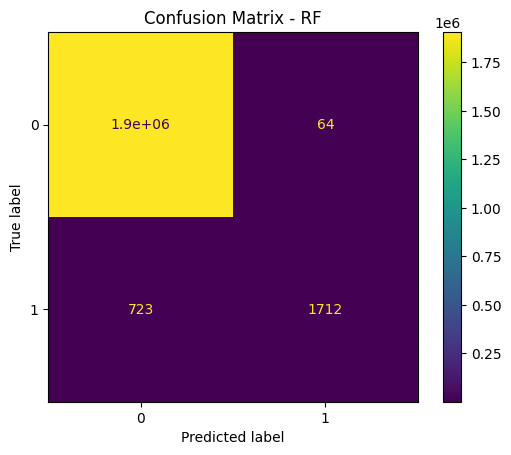

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=forest_matrix)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

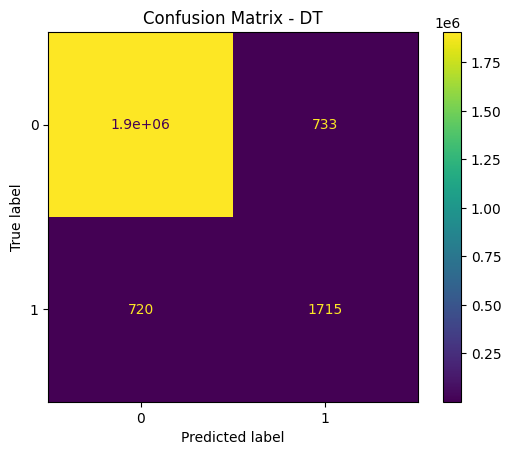

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=tree_matrix)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

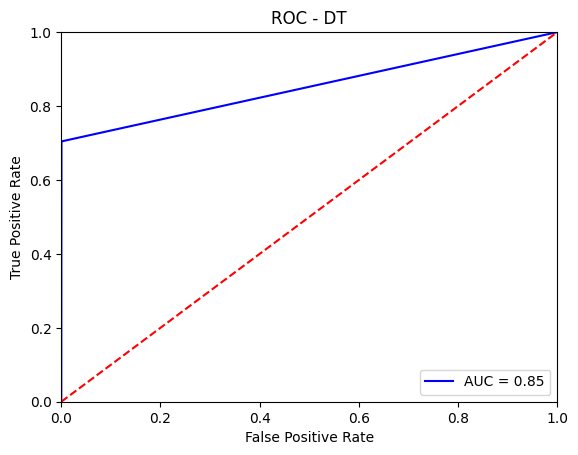

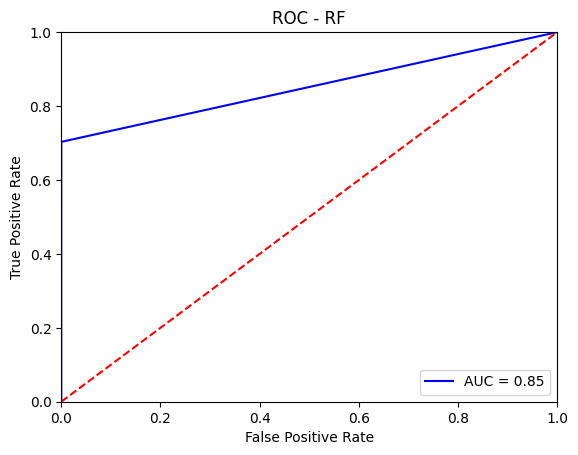

In [43]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, tree_prediction)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, forest_prediction)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**CONCLUSION**

We have seen that Accuracy of both Random Forest and Decision Tree is equal, although teh precision of Random Forest is more. In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

The source of request is secured or not ?
Is the name of organisation asking for money is legit or not ?
Transaction history of vendors.
What kind of prevention should be adopted while company update its infrastructure?

Use smart vertified apps only.
Browse through secured websites.
Use secured internet connections (USE VPN).
Keep your mobile and laptop security updated.
Don't respond to unsolicited calls/SMS(s/E-mails.
If you feel like you have been tricked or security compromised, contact your bank immidiately.

Assuming these actions have been implemented, how would you determine if they work?

Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.